C:\Users\santa\AppData\Local\Temp\ipykernel_22136\551757388.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\santa\AppData\Local\Temp\ipykernel_22136\551757388.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


R = 0.15 m, t = 1.0000 mm
L_crítico (λ=3.35): 6.154343 m

p_cr (regime longo) = 5703.70 Pa = 5.70 kPa
Fórmula: p_cr = 0.275 × E × (t/R)³
Independente de L (constante para λ > 3.35)


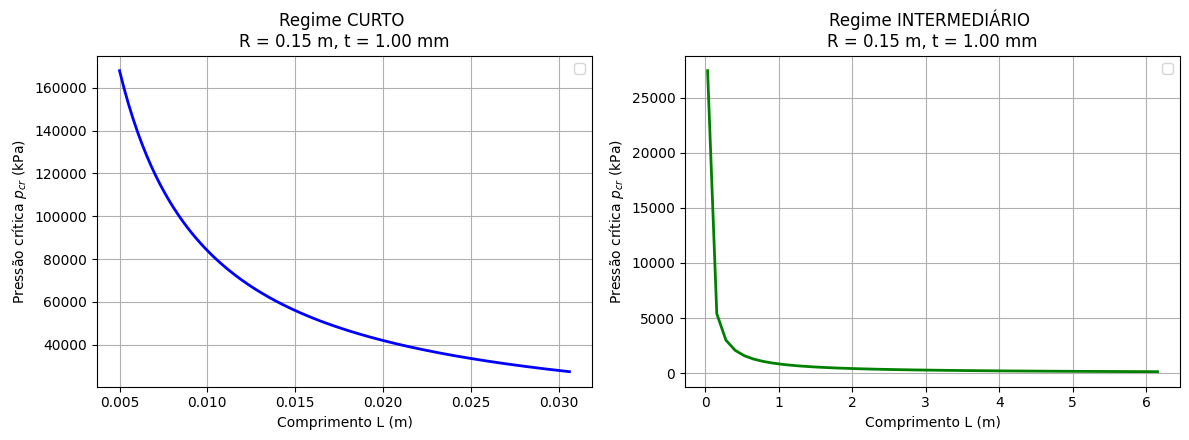

In [50]:
from math import sqrt
from typing import Iterable, Tuple, Optional, Any
import os
import numpy as np
import matplotlib.pyplot as plt

# --------- Funções do Ventsel ---------
def alpha_interp_Rsobreh(R_sobre_h: float,
                         tabela: Optional[Iterable[Tuple[float, float]]] = None) -> float:
    """Interpolação linear de α(R/h) com clamp nas bordas."""
    if tabela is None:
        tabela = [(250.0, 0.7), (500.0, 0.6), (1000.0, 0.5), (1500.0, 0.4)]
    pts = sorted((float(x), float(y)) for x, y in tabela)
    if R_sobre_h <= pts[0][0]:
        return pts[0][1]
    if R_sobre_h >= pts[-1][0]:
        return pts[-1][1]
    for (x0, y0), (x1, y1) in zip(pts[:-1], pts[1:]):
        if x0 <= R_sobre_h <= x1:
            w = (R_sobre_h - x0) / (x1 - x0)
            return y0 + w * (y1 - y0)
    return pts[-1][1]

def p_cr_ventsel(E: float, t: float, R: float, L: float, nu: Optional[float] = None, *,
                 regime: str = "auto",
                 cond_contorno: str = "simples_apoio",
                 fator_cc_personalizado: Optional[float] = None,
                 tipo_pressao_curto: str = "contorno_todo",
                 alpha1_personalizado: Optional[float] = None,
                 tabela_alpha: Optional[Iterable[Tuple[float, float]]] = None,
                 alpha_intermediate: Optional[float] = None,
                 return_details: bool = False) -> Any:
    """Pressão crítica p_cr (Pa) conforme Ventsel 19.10.1(b) com seleção automática de regime."""
    # Fator de contorno
    if fator_cc_personalizado is not None:
        fator_cc = float(fator_cc_personalizado)
    else:
        if cond_contorno == "simples_apoio":
            fator_cc = 1.0
        elif cond_contorno == "pino_engaste":
            fator_cc = 0.6
        else:
            raise ValueError("cond_contorno inválido.")

    min_L = L*2.5*sqrt(R*t)
    max_L = 3.35 * R * sqrt(R / t)
    if regime == "auto":
        if L>max_L:
            regime = "long"
        elif  L<min_L:
            regime = "short"
        else:
            reg = "intermediate"
    elif regime not in {"long", "intermediate", "short"}:
        raise ValueError("regime deve ser 'auto', 'long', 'intermediate' ou 'short'.")

    # Fórmulas
    if regime == "long":
        p_base = 0.275 * E * (t / R) ** 3
    elif regime == "intermediate":
        if nu is None:
            raise ValueError("Regime 'intermediate' requer 'nu'.")
        alpha = alpha_intermediate if alpha_intermediate is not None else alpha_interp_Rsobreh(R / t, tabela=tabela_alpha)
        p_base = 0.855 * alpha * (E * t**2) / (R * L * (1.0 - nu**2) ** (3.0 / 4.0)) * sqrt(t / R)
    else:  # short
        if alpha1_personalizado is not None:
            alpha1 = float(alpha1_personalizado)
        else:
            alpha1 = 1.8 if tipo_pressao_curto == "contorno_todo" else 3.6
        p_base = alpha1 * E * t**2 / (R * L)

    p = fator_cc * p_base
    if return_details:
        return {"p_cr": p, "regime": reg,  "fator_cc": fator_cc}
    return p

# --------- Parâmetros fixos (ajuste conforme necessário) ---------
E  = 70e9      # Pa
nu = 0.33
t  = 0.001     # m

# Saída
outdir = "figs_ventsel"
os.makedirs(outdir, exist_ok=True)

R_fix = 0.15  # m
Lcrit_short = 2.5  * sqrt(R_fix * t)   # λ=2.5
Lcrit_long  = 3.35 * R_fix * sqrt(R_fix / t)   # λ=3.35

# Regime curto: L < Lcrit_short
L_vals_short = np.linspace(0.005, Lcrit_short, 200)
pcr_L_short = np.array([p_cr_ventsel(E, t, R_fix, L, nu, regime="auto") for L in L_vals_short])

# Regime intermediário: Lcrit_short < L < Lcrit_long
L_max_inter = Lcrit_long  
L_vals_inter = np.linspace(Lcrit_short, L_max_inter, 50)
pcr_L_inter = np.array([p_cr_ventsel(E, t, R_fix, L, nu, regime="auto") for L in L_vals_inter])

# Regime longo: L > Lcrit_long (independe de L)
p_cr_long = p_cr_ventsel(E, t, R_fix, Lcrit_long * 2, nu, regime="long")

# Criar figura com 2 subplots
figA, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Subplot 1: Regime curto
ax1.plot(L_vals_short, pcr_L_short/1000, 'b-', linewidth=2)
ax1.set_xlabel("Comprimento L (m)")
ax1.set_ylabel("Pressão crítica $p_{{cr}}$ (kPa)")
ax1.set_title(f"Regime CURTO \nR = {R_fix:.2f} m, t = {t*1000:.2f} mm")
ax1.grid(True)
ax1.legend()

# Subplot 2: Regime intermediário
ax2.plot(L_vals_inter, pcr_L_inter/1000, 'g-', linewidth=2)
ax2.set_xlabel("Comprimento L (m)")
ax2.set_ylabel("Pressão crítica $p_{{cr}}$ (kPa)")
ax2.set_title(f"Regime INTERMEDIÁRIO \nR = {R_fix:.2f} m, t = {t*1000:.2f} mm")
ax2.grid(True)
ax2.legend()

figA.tight_layout()
figA.savefig(os.path.join(outdir, "pcr_vs_L_R_fix_2regimes.png"), dpi=300, bbox_inches="tight")
figA.savefig(os.path.join(outdir, "pcr_vs_L_R_fix_2regimes.pdf"), bbox_inches="tight")

print(f"R = {R_fix:.2f} m, t = {t*1000:.4f} mm")
print(f"L_crítico (λ=3.35): {Lcrit_long:.6f} m")
print(f"\np_cr (regime longo) = {p_cr_long:.2f} Pa = {p_cr_long/1e3:.2f} kPa")
print(f"Fórmula: p_cr = 0.275 × E × (t/R)³")
print(f"Independente de L (constante para λ > 3.35)")
